## confirm $\min_{s}V^{\pi_{\textrm{RL}}}(s) > \max_sV^{\pi_{\textrm{init}}}(s)$

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
import csv
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
env = gym2.make('Linear-v0')

In [10]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor


def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic, critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        mb_noise=False,
        coef_u=.01,
        coef_tau=.001,
        action_clipper=[-10., 10.],
        tau_clipper=[0.001, 1.],
        params_logging=False,
        gradient_logging=False,
        batch_size=128,
    )
    return agent

def array_exp(A):
    v, p = np.linalg.eig(A)
    align = np.array([[v[0], 0],[0, v[1]]])
    exp = np.exp(align)
    exp[~np.eye(exp.shape[0],dtype=bool)] = 0
    out = np.dot(np.dot(p, exp), np.linalg.inv(p))
    return out


def next_state(state, action, tau, env):
    # next state when const action and tau is input
    A = env.A
    B = env.B
    eAt = array_exp(A*tau)
    A_inv = np.linalg.inv(A)
    
    integral = np.dot(np.dot(eAt, A_inv), B) \
             - np.dot(np.dot(eAt, A_inv), np.dot(array_exp(-A*tau), B))
    s_prime = np.dot(eAt, state) + integral *action 
    
    return s_prime

In [46]:
#learning   
l = .1
step = 1000000  # num of interval
episode_step = step
a = agent2((2,), (2,))
actor_optimizer, critic_optimizer = Adam(lr=100., clipnorm=1.), Adam(lr=0.001, clipnorm=1.) # actorの方は何でもいい
optimizer = [actor_optimizer, critic_optimizer]
a.compile(optimizer=optimizer, metrics=["mse"], action_lr=0.0001, tau_lr=0.001)

b = agent2((2,), (2,))
b.compile(optimizer=optimizer, metrics=["mse"], action_lr=0.0001, tau_lr=0.001)

In [8]:
# load model
a.load_weights('../saved_agent/linear_init.h5')

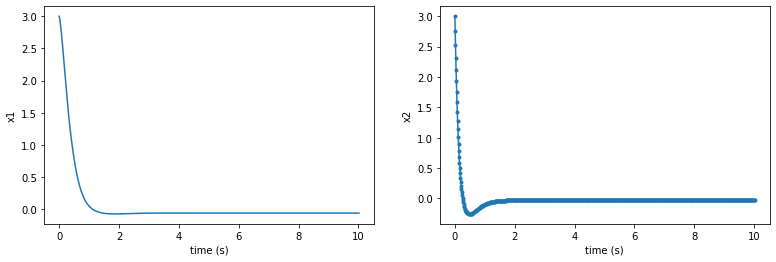

In [13]:
l = .1
env.reset()
i_state = np.array([3,3])
env.set_state(i_state)
states = []
time_limit = 10
time_log = [0]
actions = []
acc_time = 0
episode_reward = 0
while True:
    reward = 0
    x = env.state
    states.append(x)
    a_agent, tau = a.forward(x)
    actions.append([a_agent, tau])
    acc_time += tau
    time_log.append(acc_time)
    env.set_state(next_state(x, a_agent, tau, env))
    if acc_time > time_limit:
        break
states.append(env.state)
actions.append(a.forward(env.state))
states = np.array(states)
actions = np.array(actions)

plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plt.xlabel('time (s)')
plt.ylabel('x1')
plt.plot(time_log, states[:,0])
plt.subplot(1,2,2)
plt.xlabel('time (s)')
plt.ylabel('x2')
plt.plot(time_log, states[:,1])
plt.scatter(time_log, states[:,1], marker='.')
plt.show()

In [51]:
l = 1.
def value_function(state, agent, env, gamma=.99, step_limit=1000):
    env.reset()
    env.set_state(state)
    value = 0
    
    for step in range(step_limit):
        reward = 0
        x = env.state
        a_agent, tau = agent.forward(x)
        
        action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.05
        dt = tau / action_repetition
        for p in range(action_repetition):
            _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
            reward += r
        reward *= dt
        reward += - 0.01 * a_agent**2 + l * tau
        
        value += pow(gamma, step) * reward
    
    return value

In [54]:
%%time
a.load_weights('../saved_agent/linear_init.h5')
b.load_weights('../saved_agent/learned_self_linear0.h5')

s1 = np.linspace(-7, 7, 100)
s2 = np.linspace(-7, 7, 100)
S1, S2 = np.meshgrid(s1, s2)

values_init = []
values_rl = []

for state in zip(S1.flatten(), S2.flatten()):
    state = np.array(state)
    values_init.append(value_function(state, a, env))
    values_rl.append(value_function(state, b, env))
    
values_init = np.array(values_init).reshape(S1.shape)
values_rl = np.array(values_rl).reshape(S1.shape)

In [56]:
print(np.min(values_rl), np.max(values_init))

34.303085625201724 1.4786998336335386


In [53]:
%%time
## ノイズのやつ
state = np.array([6.,6.])

a.load_weights('../saved_agent/large_noise0.h5')
print(value_function(state, a, env))

a.load_weights('../saved_agent/small_noise0.h5')
print(value_function(state, a, env))

-9.697294025257953
34.39552520415214
-14.709444689856836
-6.630478880023541
CPU times: user 5.56 s, sys: 323 ms, total: 5.88 s
Wall time: 5.56 s
